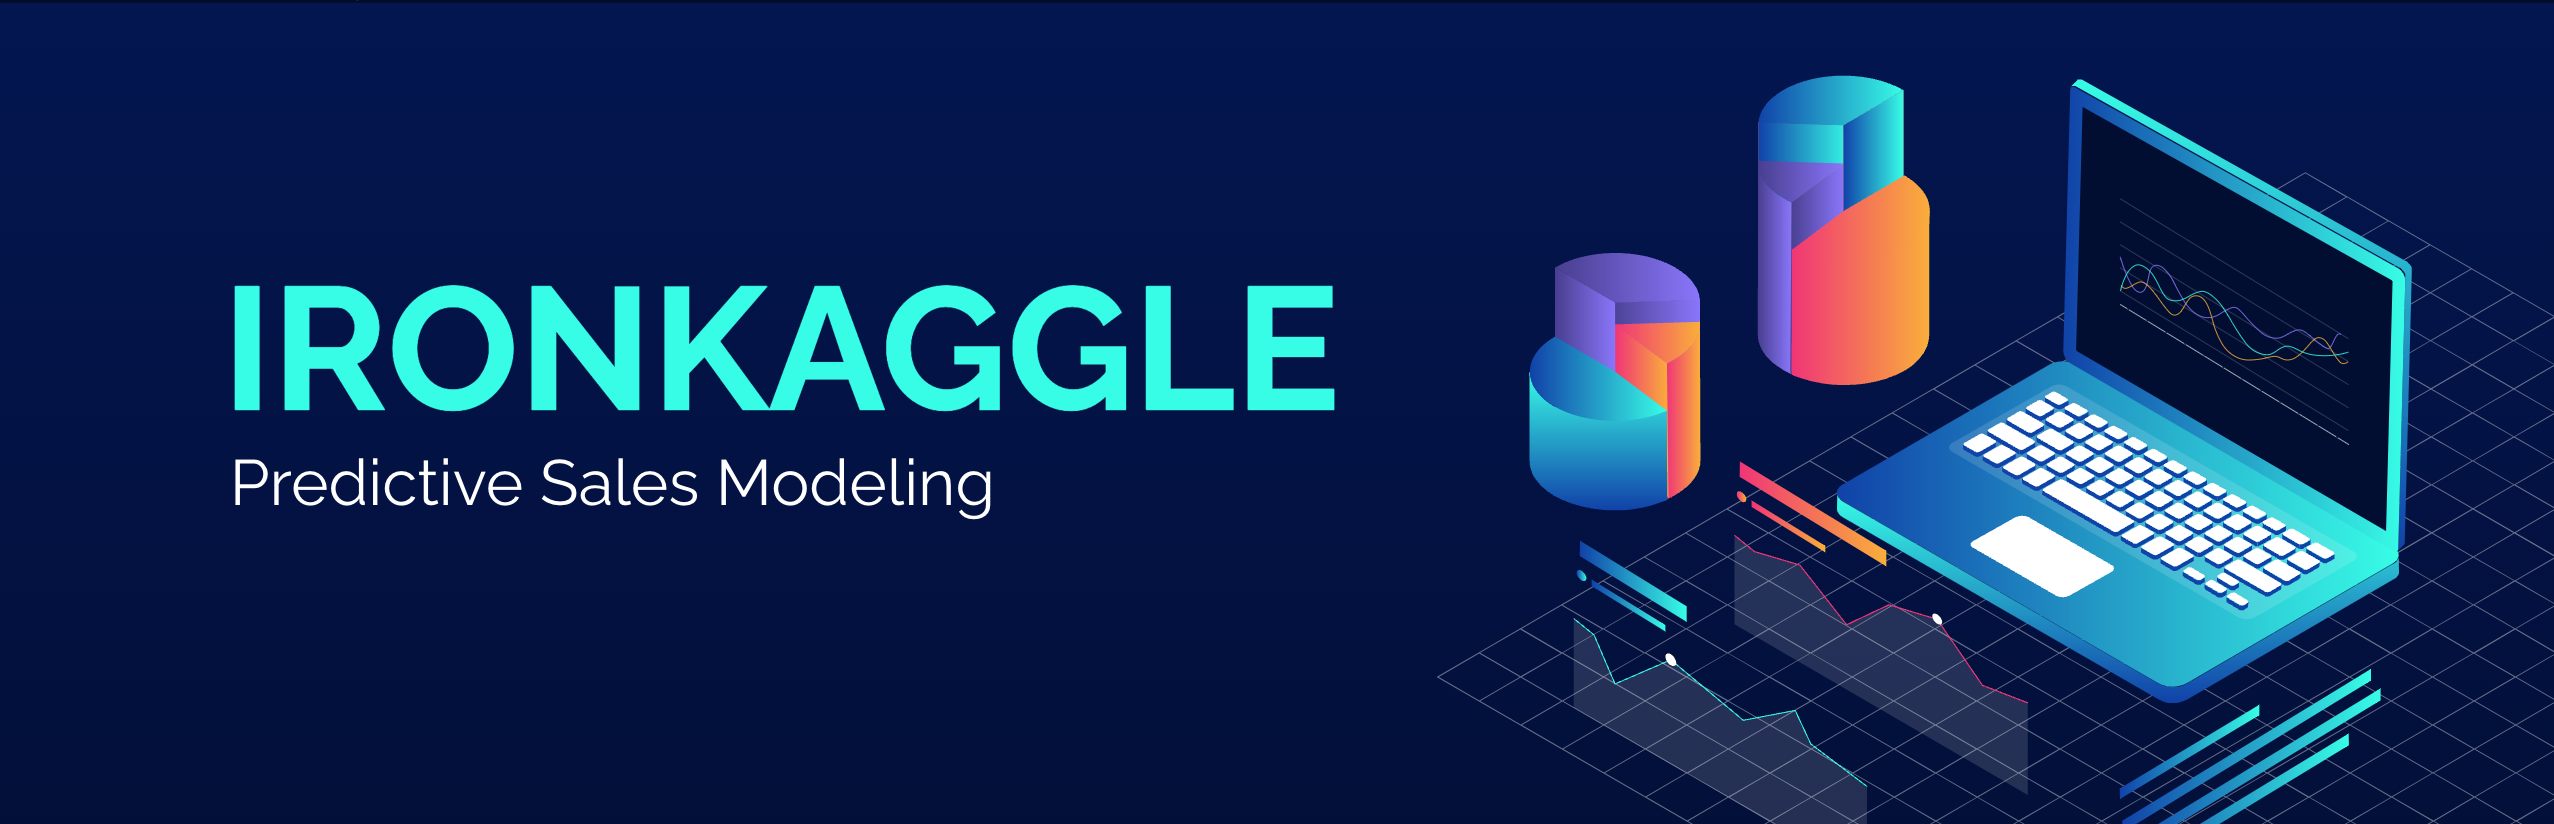

# 0 | Import Libraries

In [3]:
import pandas as pd                                                                         # Handling
import numpy as np

import matplotlib.pyplot as plt                                                             # Visualization
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder                # Preprocessing

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score  # Train-Test Split & Model Selection
                             
from sklearn.linear_model import LinearRegression                                           # ML Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor)
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.metrics import (                                                               # Metrics & Evaluation
    accuracy_score, precision_score, recall_score, f1_score, r2_score, 
    mean_absolute_error, mean_squared_error, root_mean_squared_error, classification_report, confusion_matrix
)

import pickle

pd.set_option('display.max_columns', None)

# 1 | Load Data

In [5]:
def load_data(filepath):
    """Load dataset from CSV file"""
    return pd.read_csv(filepath)

df = load_data("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/sales.csv")

# 2 | Explore Data

In [7]:
def explore_data(df):
    """Initial EDA"""
    print(df.info())
    display(df.head())
    print("\nSummary Statistics:")
    display(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum()/len(df)*100)
    print("\nDuplicated Values:")
    print(df.duplicated().sum())
    duplicates = df.duplicated().sum()
    percentage = df.duplicated().sum() / df.shape[0] * 100
    print(f'{duplicates} rows contain duplicates amounting to {percentage.round(2)}% of the total data.')
    print("\nLikely Target Value Counts:")
    print(df.iloc[:, -1].value_counts(normalize = True)*100)
    print (f"\nShape: {df.shape}")
    
explore_data(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   True_index           640840 non-null  int64 
 1   Store_ID             640840 non-null  int64 
 2   Day_of_week          640840 non-null  int64 
 3   Date                 640840 non-null  object
 4   Nb_customers_on_day  640840 non-null  int64 
 5   Open                 640840 non-null  int64 
 6   Promotion            640840 non-null  int64 
 7   State_holiday        640840 non-null  object
 8   School_holiday       640840 non-null  int64 
 9   Sales                640840 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 48.9+ MB
None


,True_index,Store_ID,Day_of_week,Date,Nb_customers_on_day,Open,Promotion,State_holiday,School_holiday,Sales
0,0,625,3,2013-11-06,641,1,1,0,0,7293
1,1,293,2,2013-07-16,877,1,1,0,1,7060
2,2,39,4,2014-01-23,561,1,1,0,0,4565
3,3,676,4,2013-09-26,1584,1,1,0,0,6380
4,4,709,3,2014-01-22,1477,1,1,0,0,11647



Summary Statistics:


,True_index,Store_ID,Day_of_week,Nb_customers_on_day,Open,Promotion,School_holiday,Sales
count,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000
mean,355990.675084,558.211348,4.000189,633.398577,0.830185,0.381718,0.178472,5777.469011
std,205536.290268,321.878521,1.996478,464.094416,0.375470,0.485808,0.382910,3851.338083
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,178075.750000,280.000000,2.000000,405.000000,1.000000,0.000000,0.000000,3731.000000
50%,355948.500000,558.000000,4.000000,609.000000,1.000000,0.000000,0.000000,5746.000000
75%,533959.250000,837.000000,6.000000,838.000000,1.000000,1.000000,0.000000,7860.000000
max,712044.000000,1115.000000,7.000000,5458.000000,1.000000,1.000000,1.000000,41551.000000



Missing Values:
True_index             0.0
Store_ID               0.0
Day_of_week            0.0
Date                   0.0
Nb_customers_on_day    0.0
Open                   0.0
Promotion              0.0
State_holiday          0.0
School_holiday         0.0
Sales                  0.0
dtype: float64

Duplicated Values:
0
0 rows contain duplicates amounting to 0.0% of the total data.

Likely Target Value Counts:
Sales
0        16.986299
5674      0.022783
6049      0.020910
5449      0.020286
5723      0.019974
           ...    
19692     0.000156
23000     0.000156
15891     0.000156
19895     0.000156
15579     0.000156
Name: proportion, Length: 20129, dtype: float64

Shape: (640840, 10)


# 3 | Data Preprocessing

#### Drop Unnecessary

In [10]:
# df = df.drop(columns = ['Open'])  # makes no sense to sell when store is closed

#### Renaming and Ordering Columns

In [12]:
df.columns

Index(['True_index', 'Store_ID', 'Day_of_week', 'Date', 'Nb_customers_on_day',
       'Open', 'Promotion', 'State_holiday', 'School_holiday', 'Sales'],
      dtype='object')

In [13]:
desired_order = ['True_index','Store_ID', 'Date', 'Day_of_week', 'State_holiday', 'School_holiday', 'Promotion', 'Nb_customers_on_day', 'Open', 'Sales']

df = df[desired_order]

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

column_mapping = {
    'true_index' : 'true_index',
    'store_id': 'store_id',
    'date': 'date',
    'day_of_week': 'weekday',
    'state_holiday': 'state_holiday',
    'school_holiday': 'school_holiday',
    'open': 'open',
    'promotion': 'promotion',
    'nb_customers_on_day':'customers_per_day',
    'sales': 'sales'
}
df.rename(columns=column_mapping, inplace=True)

#### Outliers  (leaving them actually gives better preds)

In [ ]:
def outlier_percentage_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
    return (outliers.sum() / len(df)) * 100 

outlier_percentages = outlier_percentage_iqr(df.select_dtypes(include=[np.number]))
print(outlier_percentages)

In [ ]:
def replace_outliers_with_median(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    for col in columns:
        median_value = df[col].median()
        col_lower_bound = lower_bound[col]
        col_upper_bound = upper_bound[col]
        df[col] = np.where((df[col] < col_lower_bound) | (df[col] > col_upper_bound), median_value, df[col])

    return df

df_replaced = replace_outliers_with_median(df, columns=['customers_per_day', 'sales'])

#### Data Types

In [18]:
df.dtypes

true_index            int64
store_id              int64
date                 object
weekday               int64
state_holiday        object
school_holiday        int64
promotion             int64
customers_per_day     int64
open                  int64
sales                 int64
dtype: object

In [19]:
df['date'] = pd.to_datetime(df['date'])

# 4 | Feature Engineering

###  Handling Categorical Features

> #### One-Hot-Encoding

In [23]:
df = pd.get_dummies(df, columns=['state_holiday'], dtype=int)

In [24]:
df.columns

Index(['true_index', 'store_id', 'date', 'weekday', 'school_holiday',
       'promotion', 'customers_per_day', 'open', 'sales', 'state_holiday_0',
       'state_holiday_a', 'state_holiday_b', 'state_holiday_c'],
      dtype='object')

>#### Label encoding   (works worse since it creates fake ranking)

In [26]:
# le = LabelEncoder()
# df['state_holiday'] = le.fit_transform(df['state_holiday'])

### Extracting Parts of Date Columns

In [28]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day 
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   true_index         640840 non-null  int64         
 1   store_id           640840 non-null  int64         
 2   date               640840 non-null  datetime64[ns]
 3   weekday            640840 non-null  int64         
 4   school_holiday     640840 non-null  int64         
 5   promotion          640840 non-null  int64         
 6   customers_per_day  640840 non-null  int64         
 7   open               640840 non-null  int64         
 8   sales              640840 non-null  int64         
 9   state_holiday_0    640840 non-null  int64         
 10  state_holiday_a    640840 non-null  int64         
 11  state_holiday_b    640840 non-null  int64         
 12  state_holiday_c    640840 non-null  int64         
 13  year               640840 non-null  int32   

In [30]:
desired_order = ['true_index','store_id', 'date', 'year','month','day','weekday','is_weekend', 'state_holiday_0', 'state_holiday_a','state_holiday_b','state_holiday_c', 'school_holiday', 'promotion', 'customers_per_day', 'open', 'sales']
df = df[desired_order]

In [31]:
df.to_pickle("clean_ironkaggle.pkl")

In [32]:
df.to_csv("clean_ironkaggle.csv")

# 5 | Feature Selection

> #### Looking for low correlation between features, but high correlation between features and our target.

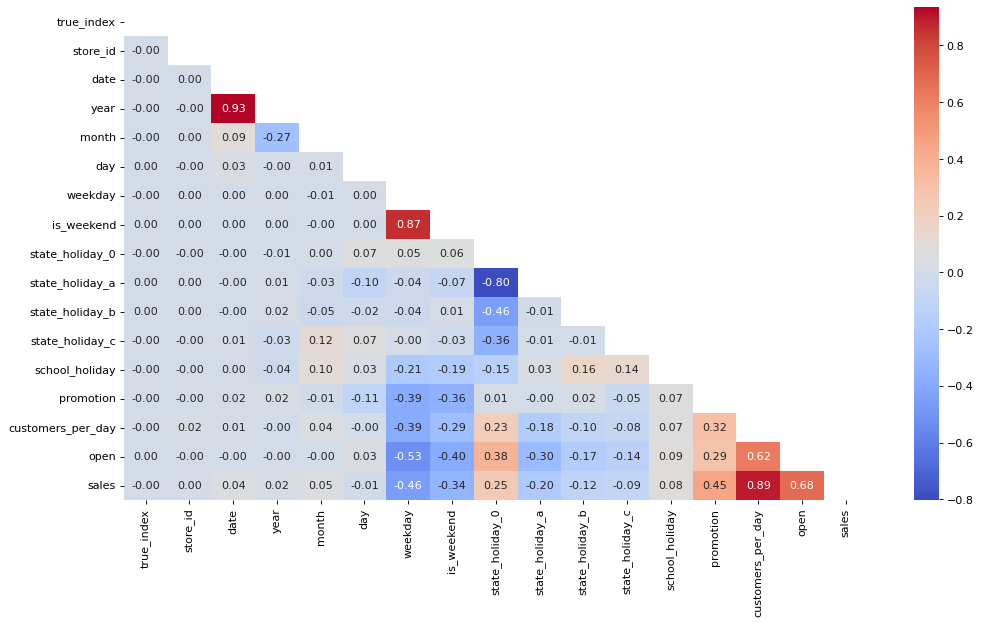

In [35]:
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix))
plt.figure(figsize=(15,8), dpi=80) 
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap="coolwarm", fmt=".2f")
plt.show()

Selecting the most relevant features (strongly correlated w/sales) while avoiding redundant or non-informative ones.
- Highly correlated with sales:
	- customers_per_day (0.89) – More customers lead to higher sales (which makes sense).
	- promotion (0.45) – Moderate positive correlation promotions boost sales, but other factors also play a role.
	- state_holiday_0 (0.25)
        -  Weak to moderate positive correlation.
        -  Regular (non-holiday) days tend to have higher sales.
        -  Negative correlations w/other state holidays suggest sales are lower on those holidays.

- Negative Correlations w/sales:
	- weekday (-0.46) & is_weekend (-0.34). Sales tend to be lower on weekends (business does better on weekdays?)
	- school_holiday (0.08, weak positive). Sales don’t seem heavily affected by school holidays.
### Key Takeaways:

✅ More customers = higher sales (very strong relationship)

✅ Promotions help boost sales significantly

✅ Weekdays outperform weekends in sales

✅ Regular (non-holiday) days have better sales than specific holidays

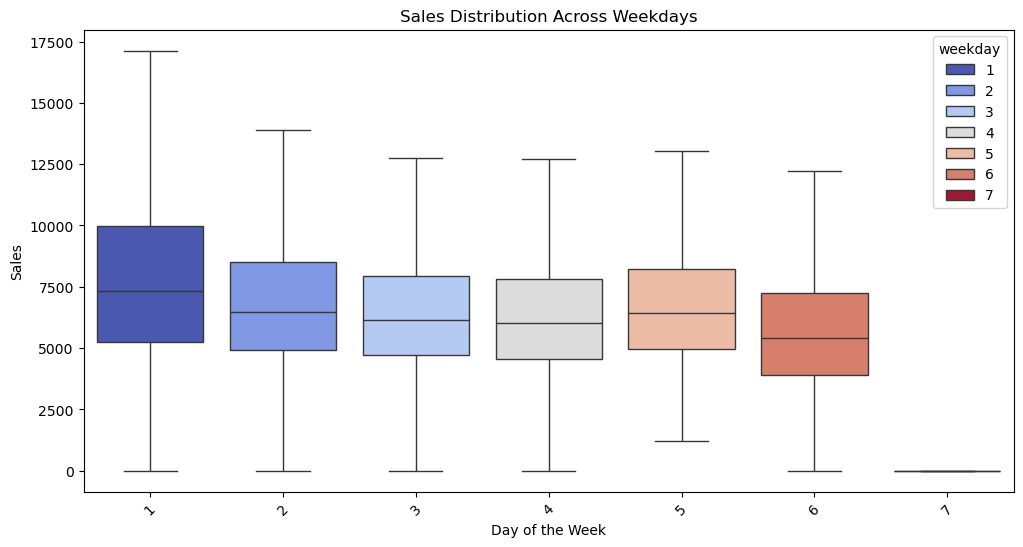

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='weekday', y='sales', data=df, showfliers=False, hue="weekday", palette="coolwarm")
plt.xlabel("Day of the Week")
plt.ylabel("Sales")
plt.title("Sales Distribution Across Weekdays")
plt.xticks(rotation=45)
plt.show()

# 6 | Train-Test Split

In [39]:
X = df.drop(columns=['date', 'sales'])
y = df['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7 | Feature Scaling

### Standardization (Z-score Normalization)
- Linear Regression, Logistic Regression, SVM, PCA

In [43]:
scaler = StandardScaler().fit(X_train) 

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

display (X_train_scaled.head())
display( X_test_scaled.head())

,true_index,store_id,year,month,day,weekday,is_weekend,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c,school_holiday,promotion,customers_per_day,open
0,0.215059,-1.457950,1.502221,-0.854759,-1.562211,-1.502777,-0.865506,0.177891,-0.14289,-0.081198,-0.064286,-0.466124,1.273383,0.094426,0.452037
1,-0.853840,-1.607074,0.215966,-0.253491,0.486805,-1.001786,-0.865506,0.177891,-0.14289,-0.081198,-0.064286,-0.466124,1.273383,-0.615719,0.452037
2,-1.295182,-0.407872,0.215966,-0.253491,0.145302,1.002177,1.155393,0.177891,-0.14289,-0.081198,-0.064286,-0.466124,-0.785310,0.148388,0.452037
3,1.555186,-0.762041,-1.070290,-0.554125,0.714473,-1.502777,-0.865506,0.177891,-0.14289,-0.081198,-0.064286,-0.466124,1.273383,0.603831,0.452037
4,1.548520,-0.497968,-1.070290,1.850947,-0.993040,1.002177,1.155393,0.177891,-0.14289,-0.081198,-0.064286,-0.466124,-0.785310,0.109535,0.452037


,true_index,store_id,year,month,day,weekday,is_weekend,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c,school_holiday,promotion,customers_per_day,open
0,0.215463,-0.678159,-1.070290,0.047143,-1.562211,1.503168,1.155393,0.177891,-0.14289,-0.081198,-0.064286,-0.466124,-0.785310,-1.366876,-2.212208
1,-0.508492,-0.174867,1.502221,-1.456027,1.055976,1.503168,1.155393,0.177891,-0.14289,-0.081198,-0.064286,-0.466124,-0.785310,-1.366876,-2.212208
2,-1.220386,-0.118946,1.502221,-0.253491,-0.993040,0.000195,-0.865506,0.177891,-0.14289,-0.081198,-0.064286,-0.466124,1.273383,-0.499161,0.452037
3,0.012064,-1.572900,0.215966,-0.554125,-0.310035,1.503168,1.155393,0.177891,-0.14289,-0.081198,-0.064286,-0.466124,-0.785310,-1.366876,-2.212208
4,0.701912,-1.035434,0.215966,1.249679,-1.106874,-1.502777,-0.865506,0.177891,-0.14289,-0.081198,-0.064286,-0.466124,1.273383,0.213143,0.452037


###  Min-Max Scaling (Normalization)
- KNN, Neural Networks, Deep Learning
- When features have different units/scales/ranges
- When you need to preserve the original range (e.g., 0-1 for probabilities)

In [45]:
normalizer = MinMaxScaler().fit(X_train)

X_train_norm = pd.DataFrame(normalizer.transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(normalizer.transform(X_test), columns=X_test.columns)

display (X_train_norm.head())
display( X_test_norm.head())

,true_index,store_id,year,month,day,weekday,is_weekend,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c,school_holiday,promotion,customers_per_day,open
0,0.561916,0.078995,1.0,0.181818,0.033333,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.124038,1.0
1,0.253377,0.035907,0.5,0.363636,0.633333,0.166667,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.063760,1.0
2,0.125983,0.382406,0.5,0.363636,0.533333,0.833333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.128619,1.0
3,0.948745,0.280072,0.0,0.272727,0.700000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.167277,1.0
4,0.946821,0.356373,0.0,1.000000,0.200000,0.833333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.125321,1.0


,true_index,store_id,year,month,day,weekday,is_weekend,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c,school_holiday,promotion,customers_per_day,open
0,0.562032,0.304309,0.0,0.454545,0.033333,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.353062,0.449731,1.0,0.000000,0.800000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.147573,0.465889,1.0,0.363636,0.200000,0.5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.073653,1.0
3,0.503321,0.045781,0.5,0.272727,0.400000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.702446,0.201077,0.5,0.818182,0.166667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.134115,1.0


# 8 |  Model Training & Evaluation

## Regression Models

#### KNN Regressor

In [49]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_norm, y_train)

print("R² Score (Train):", knn.score(X_train_norm, y_train))
print("R² Score (Test):", knn.score(X_test_norm, y_test))

R² Score (Train): 0.8697184917498961
R² Score (Test): 0.7975221060659512


#### Linear Regression Scaled

In [51]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

pred_train = lin_reg.predict(X_train_scaled)
pred_test = lin_reg.predict(X_test_scaled)

print("R² score (Train):", lin_reg.score(X_train_scaled, y_train))
print("R² score (Test):", lin_reg.score(X_test_scaled, y_test))
print("MAE (Test):", mean_absolute_error(y_test, pred_test))
print("RMSE (Test):", root_mean_squared_error(y_test, pred_test))

R² score (Train): 0.856291299949101
R² score (Test): 0.8558298594332401
MAE (Test): 985.2479485942501
RMSE (Test): 1473.256178412709


In [52]:
lin_reg_coef_scaled = {feature : coef for feature, coef in zip(X_train_scaled.columns, lin_reg.coef_)}
lin_reg_coef_scaled

{'true_index': -0.2077388690179976,
 'store_id': -46.65552805272139,
 'year': 111.87674587917066,
 'month': 107.88821537990567,
 'day': 8.023840620083348,
 'weekday': -452.15209983260974,
 'is_weekend': 329.79846916276165,
 'state_holiday_0': 22788225152779.344,
 'state_holiday_a': 18505847550432.457,
 'state_holiday_b': 10660557560909.236,
 'state_holiday_c': 8460815760845.896,
 'school_holiday': 23.19163957886084,
 'promotion': 636.2970212675475,
 'customers_per_day': 2792.9360278173544,
 'open': 533.986341435544}

#### Linear Regression Normalized

In [54]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_norm, y_train)
pred_train = lin_reg.predict(X_train_norm)
pred_test = lin_reg.predict(X_test_norm)

print("R² score (Train):", lin_reg.score(X_train_norm, y_train))
print("R² score (Test):", lin_reg.score(X_test_norm, y_test))
print("MAE (Test):", mean_absolute_error(y_test, pred_test))
print("RMSE (Test):", root_mean_squared_error(y_test, pred_test))

R² score (Train): 0.8562912800125444
R² score (Test): 0.8558302767566296
MAE (Test): 985.2623924263467
RMSE (Test): 1473.2540461240653


In [55]:
lin_reg_coef_norm = {feature : coef for feature, coef in zip(X_train_norm.columns, lin_reg.coef_)}
lin_reg_coef_norm

{'true_index': -0.7180183536009258,
 'store_id': -161.57696722636263,
 'year': 287.78890373079975,
 'month': 356.7794947000686,
 'day': 27.118833659147338,
 'weekday': -1359.060732243952,
 'is_weekend': 666.3760303448013,
 'state_holiday_0': 333772845615050.06,
 'state_holiday_a': 333772845614301.56,
 'state_holiday_b': 333772845613780.1,
 'state_holiday_c': 333772845614638.8,
 'school_holiday': 60.517569485061316,
 'promotion': 1309.9589525930285,
 'customers_per_day': 32903.673886663506,
 'open': 1422.6830748381935}

#### Random Forest Regressor

In [57]:
forest = RandomForestRegressor(n_estimators=10,
                               max_depth=3, 
                               random_state=1) 
forest.fit(X_train, y_train)

pred = forest.predict(X_test)

print("R² score (Train):", forest.score(X_train, y_train))
print("R² score (Test):", forest.score(X_test, y_test))
print("MAE (Test):", mean_absolute_error(y_test, pred_test))
print("RMSE (Test):", root_mean_squared_error(y_test, pred_test))

R² score (Train): 0.8174598595060447
R² score (Test): 0.8151437133174202
MAE (Test): 985.2623924263467
RMSE (Test): 1473.2540461240653


#### AdaBoost Regressor

In [59]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), 
                            n_estimators=50, 
                            random_state=1 
                            )

ada_reg.fit(X_train, y_train)

pred = ada_reg.predict(X_test)

print("Test MAE", mean_absolute_error(pred, y_test))
print("Test RMSE", root_mean_squared_error(pred, y_test))
print("Test R2 score", ada_reg.score(X_test, y_test))
print("Train R2 score", ada_reg.score(X_train, y_train))

Test MAE 1386.4520533849102
Test RMSE 1850.973030107575
Test R2 score 0.7724279291884977
Train R2 score 0.7701753394527343


#### Gradient Boosting Regressor

In [61]:
gb_reg = GradientBoostingRegressor(max_depth=5, 
                                   n_estimators=50,
                                   random_state=1 
                                   )
gb_reg.fit(X_train, y_train)

pred = gb_reg.predict(X_test)

print("Test MAE", mean_absolute_error(pred, y_test))
print("Test RMSE", root_mean_squared_error(pred, y_test))
print("Test R2 score", gb_reg.score(X_test, y_test))
print("Train R2 score", gb_reg.score(X_train, y_train))

Test MAE 851.1082453554916
Test RMSE 1266.4216755592252
Test R2 score 0.8934691358311712
Train R2 score 0.8948863060665155


#### XGBoost

In [63]:
xgb_reg = xgb.XGBRegressor()

xgb_reg.fit(X_train, y_train)

xgb_pred = xgb_reg.predict(X_test)

print("Test MAE", mean_absolute_error(xgb_pred, y_test))
print("Test RMSE", root_mean_squared_error(xgb_pred, y_test))
print("Test R2 score", xgb_reg.score(X_test, y_test))
print("Train R2 score", xgb_reg.score(X_train, y_train))

Test MAE 680.9434642848116
Test RMSE 1008.0205407161444
Test R2 score 0.9325071573257446
Train R2 score 0.9353273510932922


In [64]:
xgb_reg = xgb.XGBRegressor(n_estimators=2200, max_depth=7, learning_rate=0.1)

xgb_reg.fit(X_train, y_train)

xgb_pred = xgb_reg.predict(X_test)

print("Test MAE", mean_absolute_error(xgb_pred, y_test))
print("Test RMSE", root_mean_squared_error(xgb_pred, y_test))
print("Test R2 score", xgb_reg.score(X_test, y_test))
print("Train R2 score", xgb_reg.score(X_train, y_train))  

Test MAE 566.5901546600791
Test RMSE 882.4455544944403
Test R2 score 0.9482756853103638
Train R2 score 0.967122495174408


In [65]:
best_xgb_reg = xgb.XGBRegressor(n_estimators=2000, max_depth=10, learning_rate=0.05)

best_xgb_reg.fit(X_train, y_train)

xgb_pred = best_xgb_reg.predict(X_test)

print("Test MAE", mean_absolute_error(xgb_pred, y_test))
print("Test RMSE", root_mean_squared_error(xgb_pred, y_test))
print("Test R2 score", xgb_reg.score(X_test, y_test))
print("Train R2 score", xgb_reg.score(X_train, y_train))    

Test MAE 554.4303498621464
Test RMSE 875.9190485201827
Test R2 score 0.9482756853103638
Train R2 score 0.967122495174408


In [66]:
xgb_reg = xgb.XGBRegressor(n_estimators=2500, max_depth=7, learning_rate=0.1)

xgb_reg.fit(X_train, y_train)

xgb_pred = xgb_reg.predict(X_test)

print("Test MAE", mean_absolute_error(xgb_pred, y_test))
print("Test RMSE", root_mean_squared_error(xgb_pred, y_test))
print("Test R2 score", xgb_reg.score(X_test, y_test))
print("Train R2 score", xgb_reg.score(X_train, y_train))   

Test MAE 565.4370045236282
Test RMSE 881.7843593299973
Test R2 score 0.9483531713485718
Train R2 score 0.968902587890625


Observations & Best Model Choice
- Increasing trees (2000 → 2500) improves performance slightly:
- Test MAE and RMSE decrease (lower error = better).
- Test R² increases (higher R² = better fit).
- Train R² also increases, but we need to check for overfitting.
- Risk of Overfitting
- Train R² is rising steadily (0.967 → 0.969) while Test R² improves only slightly (0.9483 → 0.9484).
- The gap between Train R² and Test R² is widening, suggesting 2500 trees might be overfitting slightly.
  
✅ XGB 2000 is the best balance between performance and generalization.
- Lower error (MAE, RMSE).
- Improves Test R² but does not overfit as much as XGB 2500.

#### Hypertuning XGBoost

In [69]:
print(xgb_reg.get_params().keys())       # all valid hyperparameters

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'device', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'multi_strategy', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])


In [70]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

grid = {                                         # def hyperparameter grid
    'n_estimators': [2000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.2],
}
grid_search = GridSearchCV(                      # perform grid search cross-validation
    xgb, param_grid=grid,  
    scoring='neg_mean_squared_error', 
    cv=5, verbose=1, n_jobs=-1
)

grid_search.fit(X_train, y_train)                    # train the grid search model

print("Best Parameters:", grid_search.best_params_)      # retrieve best hyperparameters

best_xgb = grid_search.best_estimator_                   # extract best model

y_pred = best_xgb.predict(X_test)                        # retrieve best-trained

print("MAE:", mean_absolute_error(y_test, y_pred))                   # evaluate
print("RMSE:", root_mean_squared_error(y_test, y_pred))  
print("R² Score:", best_xgb.score(X_test, y_test))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 2000}
MAE: 554.4303498621464
RMSE: 875.9190485201827
R² Score: 0.9490379691123962


In [71]:
y_pred = best_xgb.predict(X_train)

print("MAE", mean_absolute_error(y_pred, y_train))
print("RMSE", root_mean_squared_error(y_train, y_pred))
print("R2 score", best_xgb.score(X_train, y_train))

MAE 342.4662283992353
RMSE 515.9761294308673
R2 score 0.9819836616516113


<Axes: ylabel='None'>

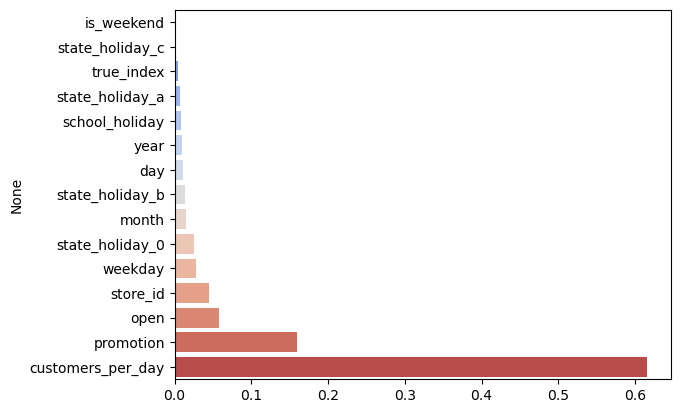

In [72]:
feature_importance = best_xgb.feature_importances_
features = X_train.columns
sorted_idx = np.argsort(feature_importance)
sns.barplot(x=feature_importance[sorted_idx], 
            y=features[sorted_idx], 
            hue=features[sorted_idx],  
            legend=False,             
            palette="coolwarm")

#### LightGBM

In [74]:
lgb_model = lgb.LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1)
lgb_model.fit(X_train, y_train)

y_pred_test_lgb = lgb_model.predict(X_test)
y_pred_train_lgb = lgb_model.predict(X_train)

print("Test MAE:", mean_absolute_error(y_test, y_pred_test_lgb))
print("Test RMSE:", root_mean_squared_error(y_test, y_pred_test_lgb))
print("Test R² Score:", lgb_model.score(X_test, y_test))
print("Train R² Score:", lgb_model.score(X_train, y_train)) 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 512672, number of used features: 15
[LightGBM] [Info] Start training from score 5775.843565
Test MAE: 797.1626072370937
Test RMSE: 1163.5294151942746
Test R² Score: 0.9100764354157893
Train R² Score: 0.9115847925604162


# 9 | Best Model

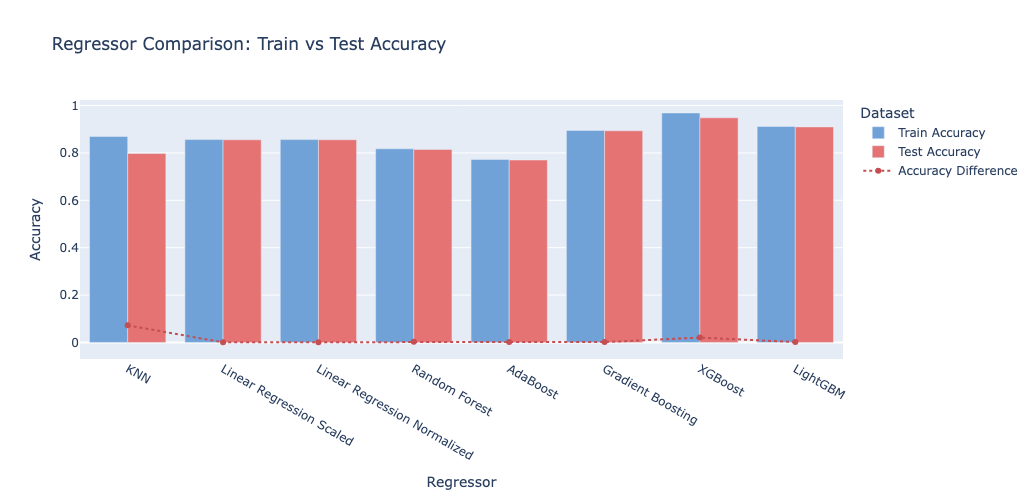

In [93]:
metrics_by_model = {
    "Regressor": ["KNN", "Linear Regression Scaled", "Linear Regression Normalized", "Random Forest",  
                  "AdaBoost", "Gradient Boosting", "XGBoost", "LightGBM"],
    "Train Accuracy": [0.8697, 0.8563, 0.8563, 0.8175, 0.7724, 0.8949, 0.9689, 0.9116], 
    "Test Accuracy": [0.7975, 0.8558, 0.8558, 0.8151, 0.7702, 0.8935, 0.9484, 0.9101]
}
model_metrics = pd.DataFrame(metrics_by_model)
model_metrics["Accuracy Difference"] = model_metrics["Train Accuracy"] - model_metrics["Test Accuracy"]
soft_colors = {
    "Train Accuracy": "#70A1D7", 
    "Test Accuracy": "#E57373"   
}
fig = px.bar(model_metrics, x="Regressor", y=["Train Accuracy", "Test Accuracy"],
             title="Regressor Comparison: Train vs Test Accuracy",
             labels={"value": "Accuracy", "variable": "Dataset"},
             barmode="group",
             height=500,
             color_discrete_map=soft_colors)
fig.add_scatter(x=model_metrics["Regressor"], 
                y=model_metrics["Accuracy Difference"], 
                name="Accuracy Difference", 
                line=dict(color='#C44E52', width=2, dash="dot")) 
fig.show()

In [95]:
data = {
    'Model': ['XGB 2000', 'XGB 2200', 'XGB 2500'],
    'Test MAE': [558.1090409756519, 556.5501948134986, 554.6246034806569],
    'Test RMSE': [872.9997898089711, 872.1007623043242, 871.5262717547525],
    'Test R²': [0.9493771195411682, 0.9494813084602356, 0.9495478272438049],
    'Train R²': [0.9642001986503601, 0.9654168486595154, 0.966838002204895]
}
XGB_metrics_final = pd.DataFrame(data)

display(XGB_metrics_final)

,Model,Test MAE,Test RMSE,Test R²,Train R²
0,XGB 2000,558.109041,872.999790,0.949377,0.964200
1,XGB 2200,556.550195,872.100762,0.949481,0.965417
2,XGB 2500,554.624603,871.526272,0.949548,0.966838


# 10 | Save Model

In [97]:
# fitting on full data before deployment ensures maximum learning
best_xgb_reg.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [99]:
with open('best_xgb_reg.pkl', 'wb') as file:
    pickle.dump(best_xgb_reg, file)

# 11 | Save Data

In [101]:
X_train.to_pickle('train_data.pkl')
y_train.to_pickle('train_label.pkl')

X_test.to_pickle('test_data.pkl')
y_test.to_pickle('test_label.pkl')

with open('best_xgb_reg.pkl', 'rb') as f:
    best_xgb_reg = pickle.load(f)

# 12 | Next Steps

In [ ]:
with open('best_xgb_reg.pkl', 'rb') as f:
    best_xgb_reg = pickle.load(f)
    
new_data = pd.read_csv('path_to_new_data.csv')

predictions = best_xgb_reg.predict(new_data)